## shrek sampler distillation exploration

I had an idea for making small models way better, I don't think it'll work, but it's a useful explanation for Entropix and the intuition. I will assume that the reader has a general familiarity with LLM's and some statistics.

## Background

LLM's operate by computing a probability distribution over the next token. At each step, we have the entire distribution of logits but use very little information here when sampling the token. In particular, we only use the logits themselves in nearly all existing sampling techniques.

The simplest sampler is to pick the most likely token at each step. Most approaches sample with weighted probabilities and apply probability scaling (temperature) or filter the number of possible tokens to sample from (min-p, top-k, etc). The Entropix work instead aims to use entropy and varentropy to drive the sampler's parameters and choices. 

In statistics, we have a notion of *moments*. In this context, the first moment is entropy, and the second moment is entropy. But we can also extend this to the third and fourth moments.

1. Entropy: represents average information content
2. Varentropy: measures how 'spiky' vs uniform the surprise is in the distribution
3. Skew: measures asymetry in surprise distribution
4. Kurtosis: measures whether extreme surprises are more or less common than normal distribution

We've added computation for skew and kurtosis to the sampler code.



In [1]:
import pandas as pd

df = pd.read_parquet("hf://datasets/tatsu-lab/alpaca/data/train-00000-of-00001-a09b74b3ef9c3b56.parquet")

df.head()

/home/hua/code/entropix/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,instruction,input,output,text
0,Give three tips for staying healthy.,,1.Eat a balanced diet and make sure to include...,Below is an instruction that describes a task....
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye...",Below is an instruction that describes a task....
2,Describe the structure of an atom.,,"An atom is made up of a nucleus, which contain...",Below is an instruction that describes a task....
3,How can we reduce air pollution?,,There are a number of ways to reduce air pollu...,Below is an instruction that describes a task....
4,Describe a time when you had to make a difficu...,,I had to make a difficult decision when I was ...,Below is an instruction that describes a task....


In [1]:
import os

import dotenv
import openai

dotenv.load_dotenv()

client = openai.OpenAI(
  api_key=os.getenv("HYPERBOLIC_API_KEY"),
  base_url="https://api.hyperbolic.xyz/v1/",
)

We'll ask the model a problem that is a little tricky for humans to think about, but is not terribly difficult. (Taken from my internal 'quant finance bench')

For sake of display, we'll use a 3B model that gets the result wrong. I was originally experimenting with looking at larger models, but it's more useful if we look at incorrect result. Notably, because we can retokenize the result, the completion we analyze can come from anywhere.

In [4]:
# user_content = "For a 3 sets' tennis game, would you bet on it finishing in 2 sets or 3 sets, assuming each player has an equal probability of winning a set?"
user_content = "Is 1027 a prime number?"

chat_completion = client.chat.completions.create(
    # model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    model="meta-llama/Llama-3.2-3B-Instruct",
    # model="deepseek-ai/DeepSeek-V2.5",
    # model= "Qwen/Qwen2.5-72B-Instruct",
    messages=[
        # {"role": "system", "content": system_content},
        {"role": "user", "content": user_content},
    ],
    temperature=0.7,
    max_tokens=1024,
    # logprobs=True,
    # top_logprobs=20,
)


Note: this result is incorrect. The correct logic is to realize that `1027 = 1000 + 27 = 10^3 + 3^3`. At this point, you would recognize that the sum of cubes implies that the number can be represented as a multiple of two things. I don't remember what those are off top of head but knowing that a factorization exists is sufficient to disprove the number being prime.

(the exact formulation is `a^3 + b^3 = (a+b)(a^2-ab+b^2)`)

The LLM's generally check primes by bruteforcing primes up to sqrt x. None in my testing find the clever solution. It's a little pattern-matchy but that's the interview game.

In [2]:
import pprint

pprint.pprint(chat_completion.choices[0].message.content)

NameError: name 'chat_completion' is not defined

Load the weights. Note that we use the base model because it should be a better representation of the 'true distribution' - instruct models have gone through too much SFT (written by underpaid contractors) and RLHF (overfit to random artifacts).

In [3]:
from pathlib import Path

import torch

from entropix.config import LLAMA_1B_PARAMS
from entropix.tokenizer import Tokenizer
from entropix.torch_kvcache import KVCache
from entropix.torch_main import build_attn_mask, precompute_freqs_cis
from entropix.torch_model import xfmr
from entropix.torch_sampler import calculate_metrics
from entropix.torch_weights import load_weights

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.inference_mode():
    model_params = LLAMA_1B_PARAMS
    xfmr_weights = load_weights(ckpt_dir=Path("weights/1B-Base"), should_compare_outputs=True)

    tokenizer = Tokenizer('entropix/tokenizer.model')
    bsz = 1
    kvcache = KVCache.new(model_params.n_layers, bsz, model_params.max_seq_len, model_params.n_local_kv_heads, model_params.head_dim).to(DEVICE)


Using device: cuda

We do a single forward pass over all of the tokens. This computes the logits at each timestep (and attention scores), so we can look at everything without needing to do autoregressive decoding. Super efficient.

In [9]:
def compute_statistics(prompt, completion):
    stats_arr = []
    with torch.inference_mode():
        prefill_str = f"""<|begin_of_text|><|start_header_id|>user<|end_header_id|>
        {prompt}
        <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
        prefill_tokens = tokenizer.encode(prefill_str, bos=False, eos=False, allowed_special='all')

        result_str = f"""{completion}<|eot_id|>"""

        joined_str = prefill_str + "\n" + result_str

        joined_tokens = tokenizer.encode(joined_str,  bos=False, eos=False, allowed_special='all')

        tokens = torch.tensor([joined_tokens], dtype=torch.long).to(DEVICE)
        seqlen = tokens.size(1)

        cur_pos = 0
        freqs_cis = precompute_freqs_cis(model_params.head_dim, model_params.max_seq_len, model_params.rope_theta, model_params.use_scaled_rope) 
        attn_mask = build_attn_mask(seqlen, cur_pos)
        bsz, seqlen = tokens.shape

        kvcache = KVCache.new(model_params.n_layers, bsz, model_params.max_seq_len, model_params.n_local_kv_heads, model_params.head_dim).to(DEVICE)

        logits, kvcache, scores, _ = xfmr(xfmr_weights, model_params, tokens, cur_pos, freqs_cis[:seqlen], kvcache, attn_mask=attn_mask)


        for i in range(len(prefill_tokens), len(joined_tokens) - 1):
            ground_truth_token_str = tokenizer.decode([joined_tokens[i + 1]]).encode("unicode_escape").decode("utf-8")
            
            # compute statistics for each token
            mx = calculate_metrics(logits[:, i, :], scores[:, :, :i, :i], i)
            mx_clean = {k: v.item() for k, v in mx.items()}

            mx_results = {}

            # what is the probability of the ground truth token, in the model's output?
            prob = torch.nn.functional.softmax(logits[:, i, :], dim=-1)
            prob_gt = prob[0, joined_tokens[i+1]].item()
            mx_results["prob"] = prob_gt

            # what is the rank of the ground truth token?
            _, topk = torch.topk(prob, k=10000, dim=-1)
            topk = topk[0].tolist()
            try:
                mx_results["rank"] = topk.index(joined_tokens[i+1])
            except ValueError:
                mx_results["rank"] = -1

            # what was the top greedy token?
            mx_results["top1"] = tokenizer.decode([topk[0]]).encode("unicode_escape").decode("utf-8")

            outcome = ""
            if mx_results["rank"] == 0 and mx_results["prob"] > 0.75:
                # this, in practice, might just be adaptive sample
                outcome = "greedy"
            elif mx_results["rank"] < 10:
                if (mx_clean["logits_entropy"] ** 2) > mx_clean["logits_varentropy"]:
                    outcome = "clarify"
                else:
                    outcome = "fork"
            else:
                outcome = "resample"

            mx_dict = mx_clean | mx_results
            mx_dict['outcome'] = outcome
            mx_dict['token'] = ground_truth_token_str
            stats_arr.append(mx_dict)
            print(f"{ground_truth_token_str}\t {outcome}\t {mx_results}\t{mx_clean}")
    return stats_arr


In [29]:
stats_arr = compute_statistics(chat_completion.choices[0].message.content)

To	 resample	 {'prob': 0.0007171630859375, 'rank': 43, 'top1': '       '}	{'logits_entropy': 5.90625, 'logits_varentropy': 32.25, 'logits_skewness': 0.216796875, 'logits_kurtosis': 0.6875, 'attn_entropy': 2.234375, 'attn_varentropy': 0.6796875, 'attn_skewness': -0.265625, 'attn_kurtosis': -1.2890625, 'agreement': 0.033447265625, 'interaction_strength': 2.46875}
 determine	 resample	 {'prob': 0.00897216796875, 'rank': 10, 'top1': ' '}	{'logits_entropy': 8.5, 'logits_varentropy': 25.0, 'logits_skewness': 0.4453125, 'logits_kurtosis': 0.921875, 'attn_entropy': 2.25, 'attn_varentropy': 0.70703125, 'attn_skewness': -0.318359375, 'attn_kurtosis': -1.2265625, 'agreement': 0.03271484375, 'interaction_strength': 2.53125}
 if	 fork	 {'prob': 0.28125, 'rank': 1, 'top1': ' whether'}	{'logits_entropy': 1.9375, 'logits_varentropy': 7.6875, 'logits_skewness': 0.56640625, 'logits_kurtosis': 1.09375, 'attn_entropy': 2.296875, 'attn_varentropy': 0.6875, 'attn_skewness': -0.310546875, 'attn_kurtosis': -1

## Analysis

Let's look at the logits!

In [5]:
import pandas as pd
import plotnine as pn

df = pd.DataFrame(stats_arr)
df['index'] = df.index + 0.1


NameError: name 'stats_arr' is not defined

One way of thinking about sampling is to formulate it as a *learning to rank* problem: can we choose the 'best' token at each moment to proceed with? 

One idea I had was to assume that the output from a big model (or from human text) is ground truth of best token, and to use the entropy statistics as inputs to a classifier that chooses the right action ( accept, resample, etc). I still need to think about how to backtranslate the ground truth text to one of those actions, though.

In that framing, the source text is 'best' token and we want to see if the small model can recover a strategy to decode the best token. This model should be a much smaller model / cheaper to train than an actual LLM - and operate on frozen weights (very possibly across multiple model families).

What we see from looking at what rank the source token is, in the small model, is that most of the time (and for very long streteches), the small model 'agrees' with the draft model. This is true actually pretty often across many models. The intuition is that 'finishing sentences' is easy (starting the sentence is hard). 

This is also the intuition behind speculative decoding - most of the time, the small model will agree with the large model, and over long stretches. If we are able to 

/home/hua/code/entropix/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/hua/code/entropix/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
/home/hua/code/entropix/.venv/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


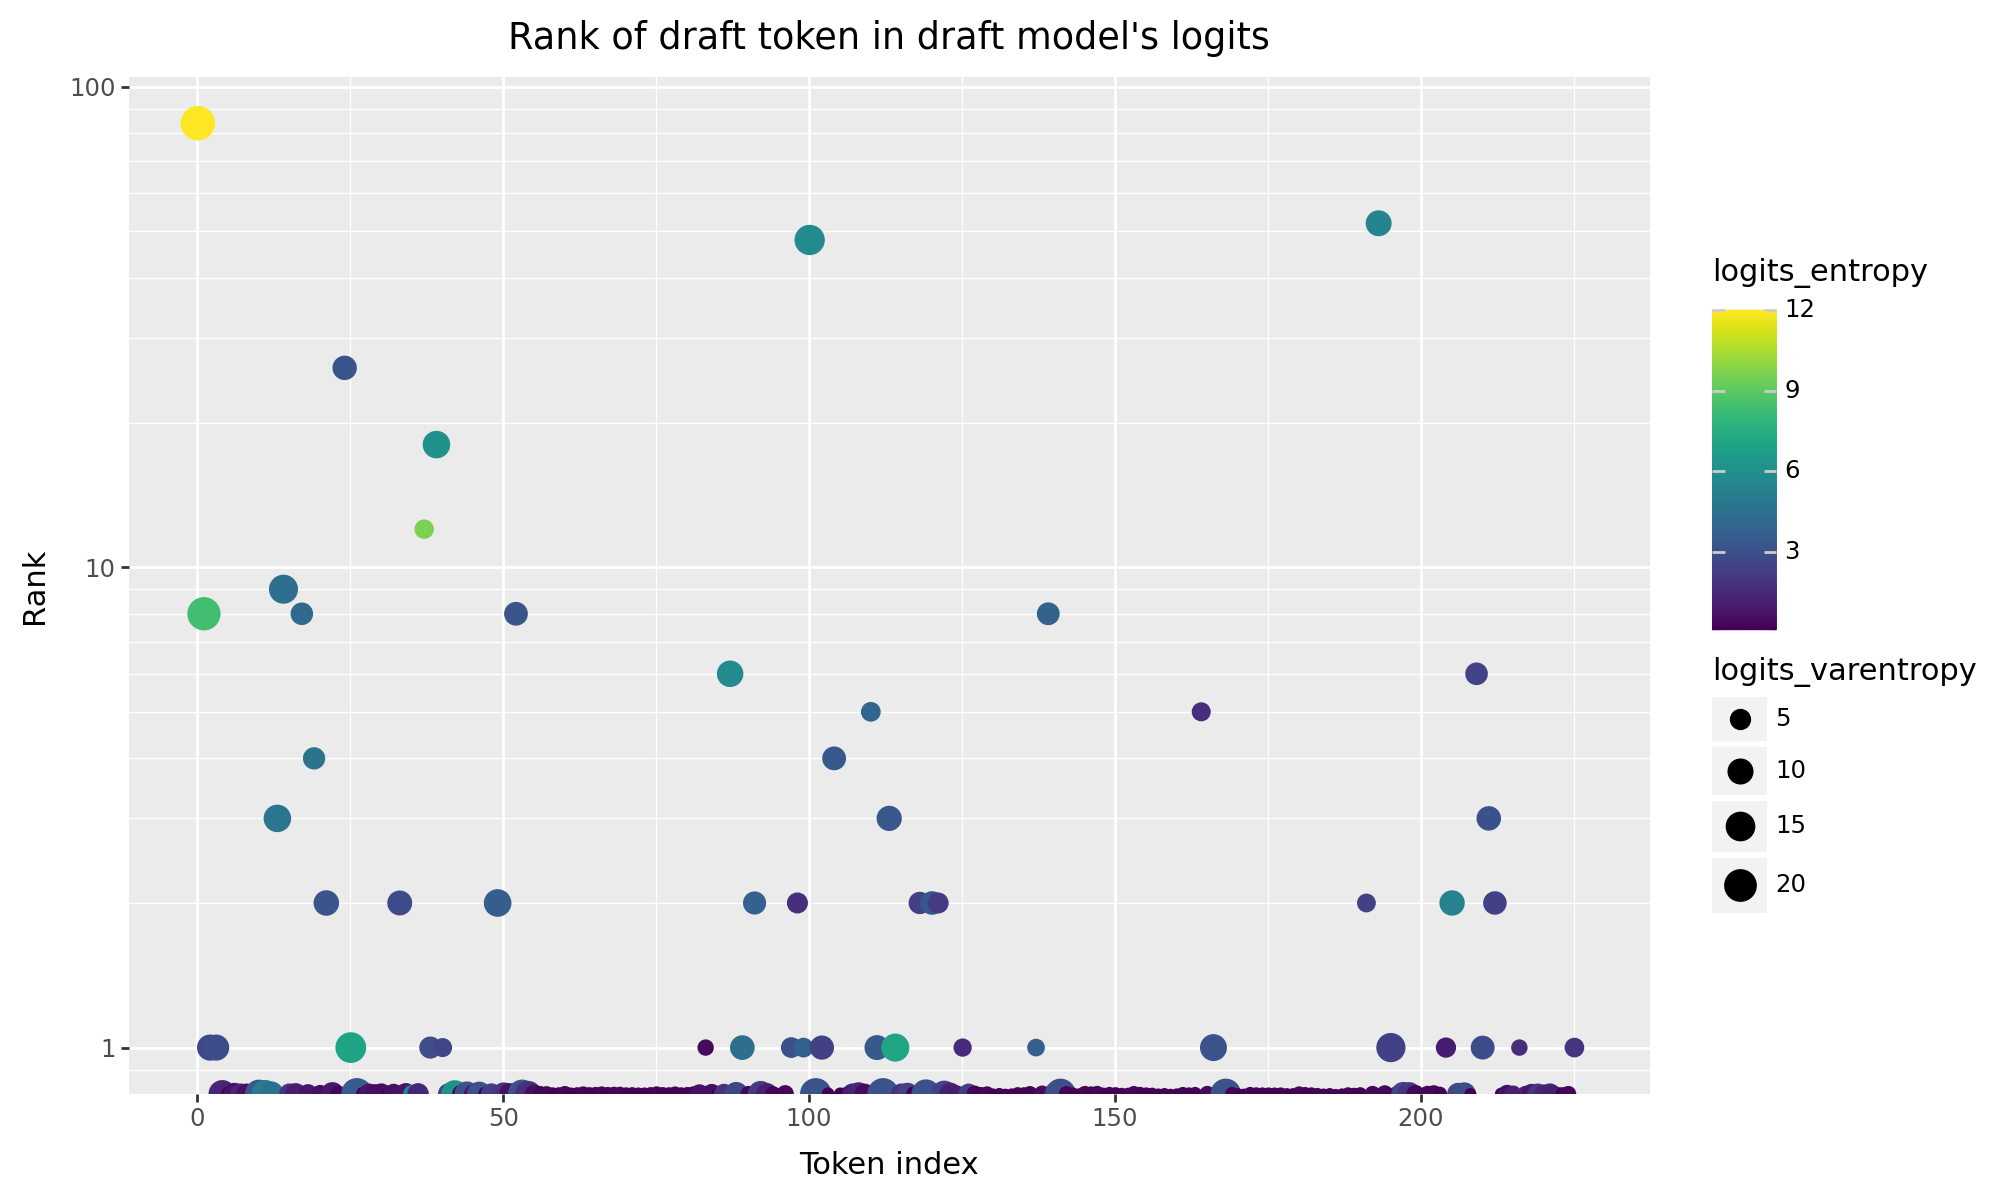

In [15]:
pn.ggplot(df, pn.aes(x="index", y="rank", color="logits_entropy", size="logits_varentropy")) + pn.geom_point() + pn.scale_y_log10() + pn.labs(title="Rank of draft token in draft model's logits", x="Token index", y="Rank") + pn.theme(figure_size=(10, 6)) 

/home/hua/code/entropix/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


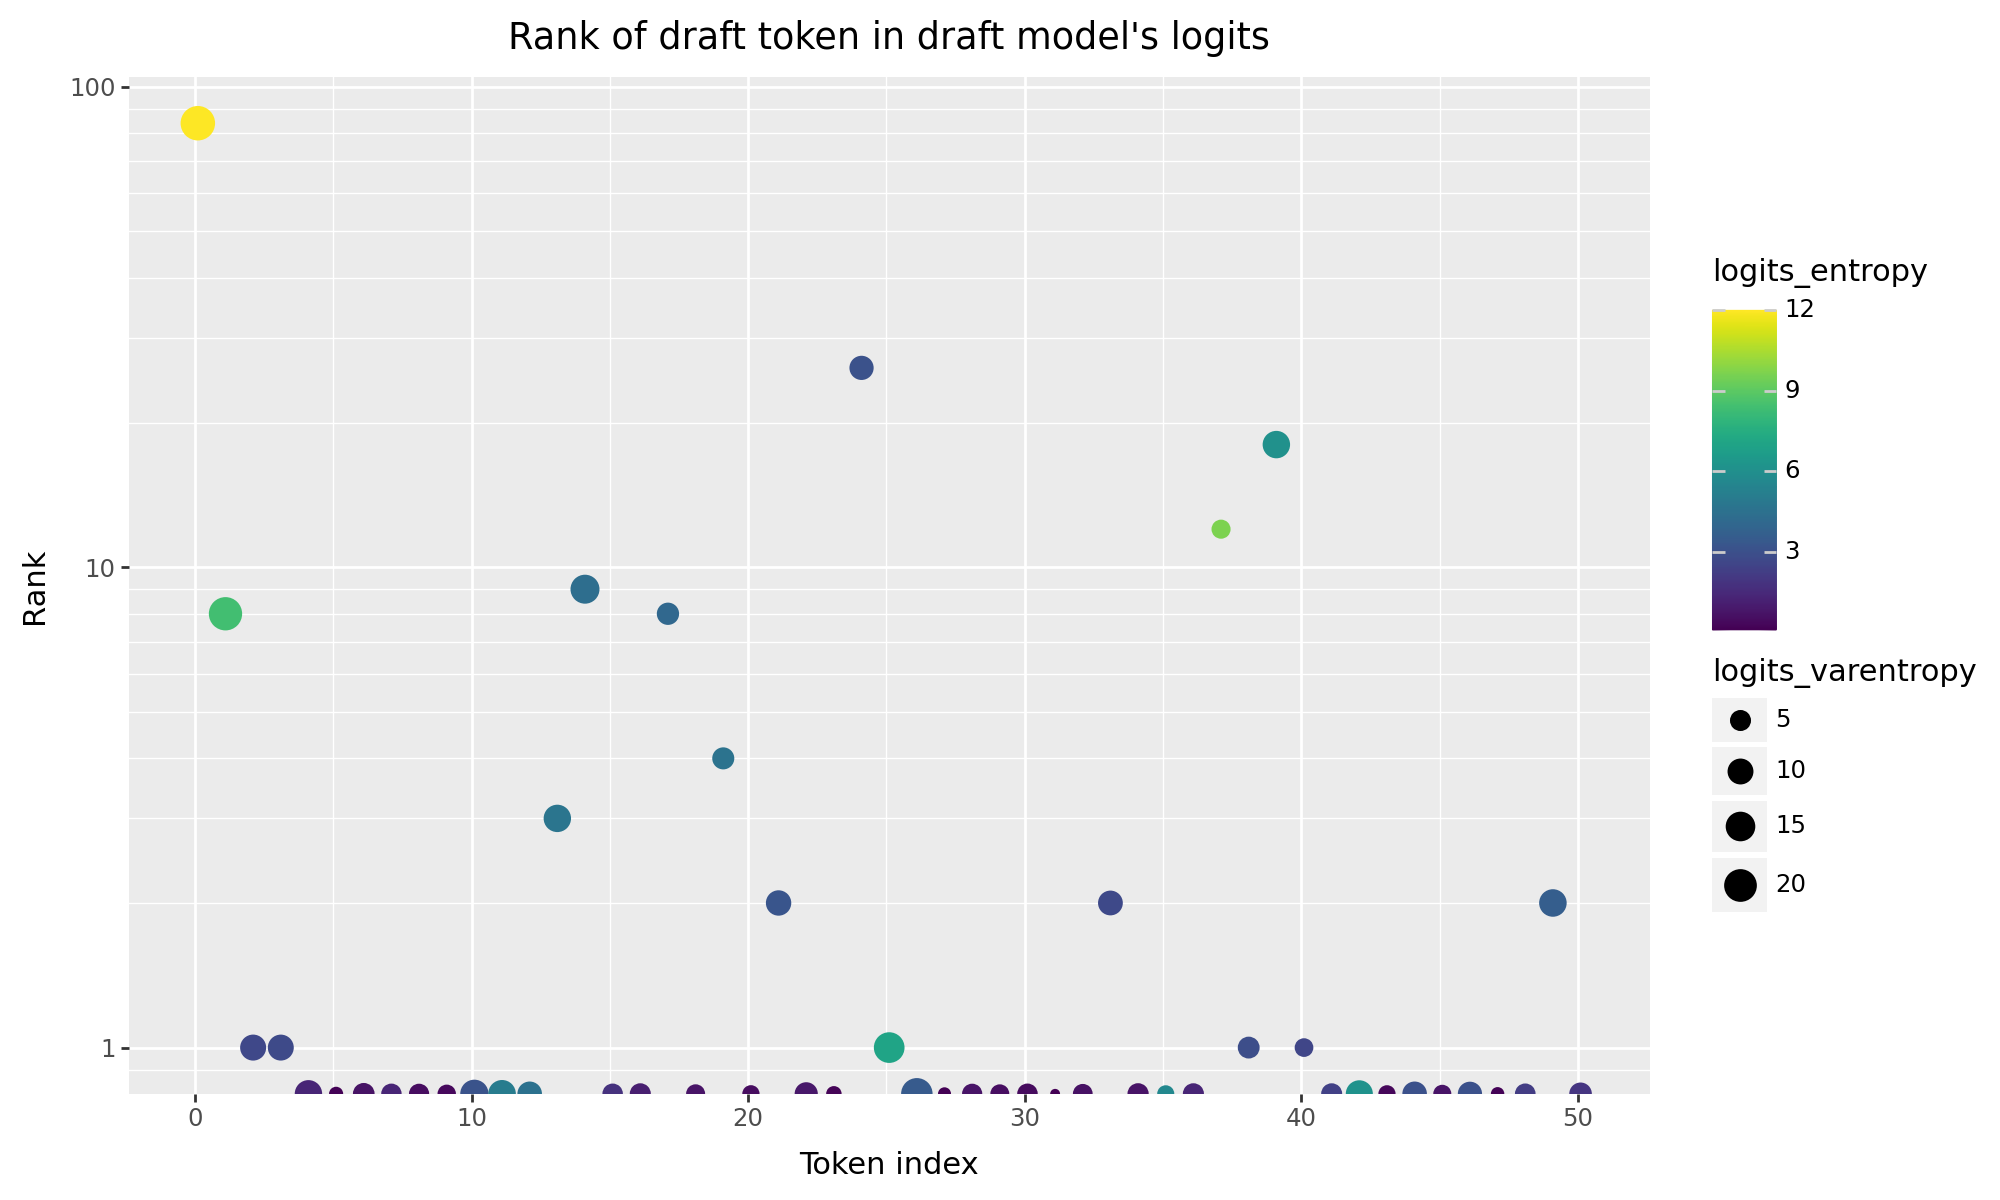

In [16]:
pn.ggplot(df.query("index < 51"), pn.aes(x="index", y="rank", color="logits_entropy", size="logits_varentropy")) + pn.geom_point() + pn.scale_y_log10() + pn.labs(title="Rank of draft token in draft model's logits", x="Token index", y="Rank") + pn.theme(figure_size=(10, 6)) 

We can also binarize the rank of the draft token - ie did we recover the top token or not - and plot that versus the entropy/varentropy of the token.

Pretty clearly if entropy is < 2.5 we can just take the top token! So one way to frame this is that we'll decode tokens from the small model UNTIL entropy is too high and then we can verify.

In [7]:
user_content_big = "Write a very long many stanza poem about the beauty of the ocean"
chat_completion_big = client.chat.completions.create(
    model="meta-llama/Meta-Llama-3.1-70B-Instruct",
    # model="meta-llama/Llama-3.2-3B-Instruct",
    # model="deepseek-ai/DeepSeek-V2.5",
    # model= "Qwen/Qwen2.5-72B-Instruct",
    messages=[
        # {"role": "system", "content": system_content},
        {"role": "user", "content": user_content_big},
    ],
    temperature=0.0,
    max_tokens=1024,
)


In [10]:
stats_arr_big = compute_statistics(user_content_big, chat_completion_big.choices[0].message.content)
df_big = pd.DataFrame(stats_arr_big)

The	 fork	 {'prob': 0.00762939453125, 'rank': 9, 'top1': '       '}	{'logits_entropy': 4.75, 'logits_varentropy': 29.0, 'logits_skewness': 0.359375, 'logits_kurtosis': 0.96875, 'attn_entropy': 2.390625, 'attn_varentropy': 0.6953125, 'attn_skewness': -0.32421875, 'attn_kurtosis': -1.0234375, 'agreement': 0.026611328125, 'interaction_strength': 2.75}
 ocean	 clarify	 {'prob': 0.125, 'rank': 0, 'top1': ' ocean'}	{'logits_entropy': 10.4375, 'logits_varentropy': 19.625, 'logits_skewness': 0.75390625, 'logits_kurtosis': 0.421875, 'attn_entropy': 2.40625, 'attn_varentropy': 0.703125, 'attn_skewness': -0.31640625, 'attn_kurtosis': -1.015625, 'agreement': 0.0263671875, 'interaction_strength': 2.78125}
's	 fork	 {'prob': 0.0240478515625, 'rank': 3, 'top1': ' is'}	{'logits_entropy': 4.59375, 'logits_varentropy': 23.875, 'logits_skewness': 0.8359375, 'logits_kurtosis': 1.09375, 'attn_entropy': 2.46875, 'attn_varentropy': 0.71484375, 'attn_skewness': -0.314453125, 'attn_kurtosis': -1.015625, 'agree

In [18]:
df_big['index'] = df_big.index + 0.1


In [11]:
df_big = df_big.assign(found_top1=lambda x: x['rank'] == 0)
df_big['would_draft'] = df_big['logits_entropy'] < 3
df_big['found_top1_count'] = df_big.groupby(
    (df_big['found_top1'] == False).cumsum()  # Creates a new group each time False is encountered
)['found_top1'].cumsum()

df_big

,logits_entropy,logits_varentropy,logits_skewness,logits_kurtosis,attn_entropy,attn_varentropy,attn_skewness,attn_kurtosis,agreement,interaction_strength,prob,rank,top1,outcome,token,found_top1,would_draft,found_top1_count
0,4.750000,29.000000,0.359375,0.968750,2.390625,0.695312,-0.324219,-1.023438,0.026611,2.750000,7.629395e-03,9,,fork,The,False,False,0
1,10.437500,19.625000,0.753906,0.421875,2.406250,0.703125,-0.316406,-1.015625,0.026367,2.781250,1.250000e-01,0,ocean,clarify,ocean,True,False,1
2,4.593750,23.875000,0.835938,1.093750,2.468750,0.714844,-0.314453,-1.015625,0.025269,2.734375,2.404785e-02,3,is,fork,'s,False,False,0
3,8.625000,16.250000,1.078125,1.281250,2.468750,0.714844,-0.324219,-0.972656,0.024170,2.750000,3.588867e-02,2,beauty,clarify,waves,False,False,0
4,7.093750,16.500000,0.976562,1.500000,2.468750,0.707031,-0.298828,-0.890625,0.022949,2.812500,2.087402e-02,4,are,clarify,crash,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.005585,0.096191,1.117188,2.687500,4.187500,2.546875,-0.460938,-0.275391,0.000805,7.125000,1.000000e+00,0,A,greedy,A,True,True,88
1021,0.006287,0.115723,0.820312,1.281250,4.187500,2.546875,-0.460938,-0.275391,0.000805,7.093750,1.000000e+00,0,story,greedy,story,True,True,89
1022,0.006378,0.096680,0.902344,1.531250,4.187500,2.546875,-0.460938,-0.275391,0.000805,7.093750,1.000000e+00,0,of,greedy,of,True,True,90
1023,0.009888,0.142578,0.902344,1.500000,4.187500,2.562500,-0.460938,-0.275391,0.000801,7.125000,1.000000e+00,0,wonder,greedy,wonder,True,True,91


/home/hua/code/entropix/.venv/lib/python3.10/site-packages/plotnine/scales/scale_continuous.py:223: RuntimeWarning: divide by zero encountered in log10


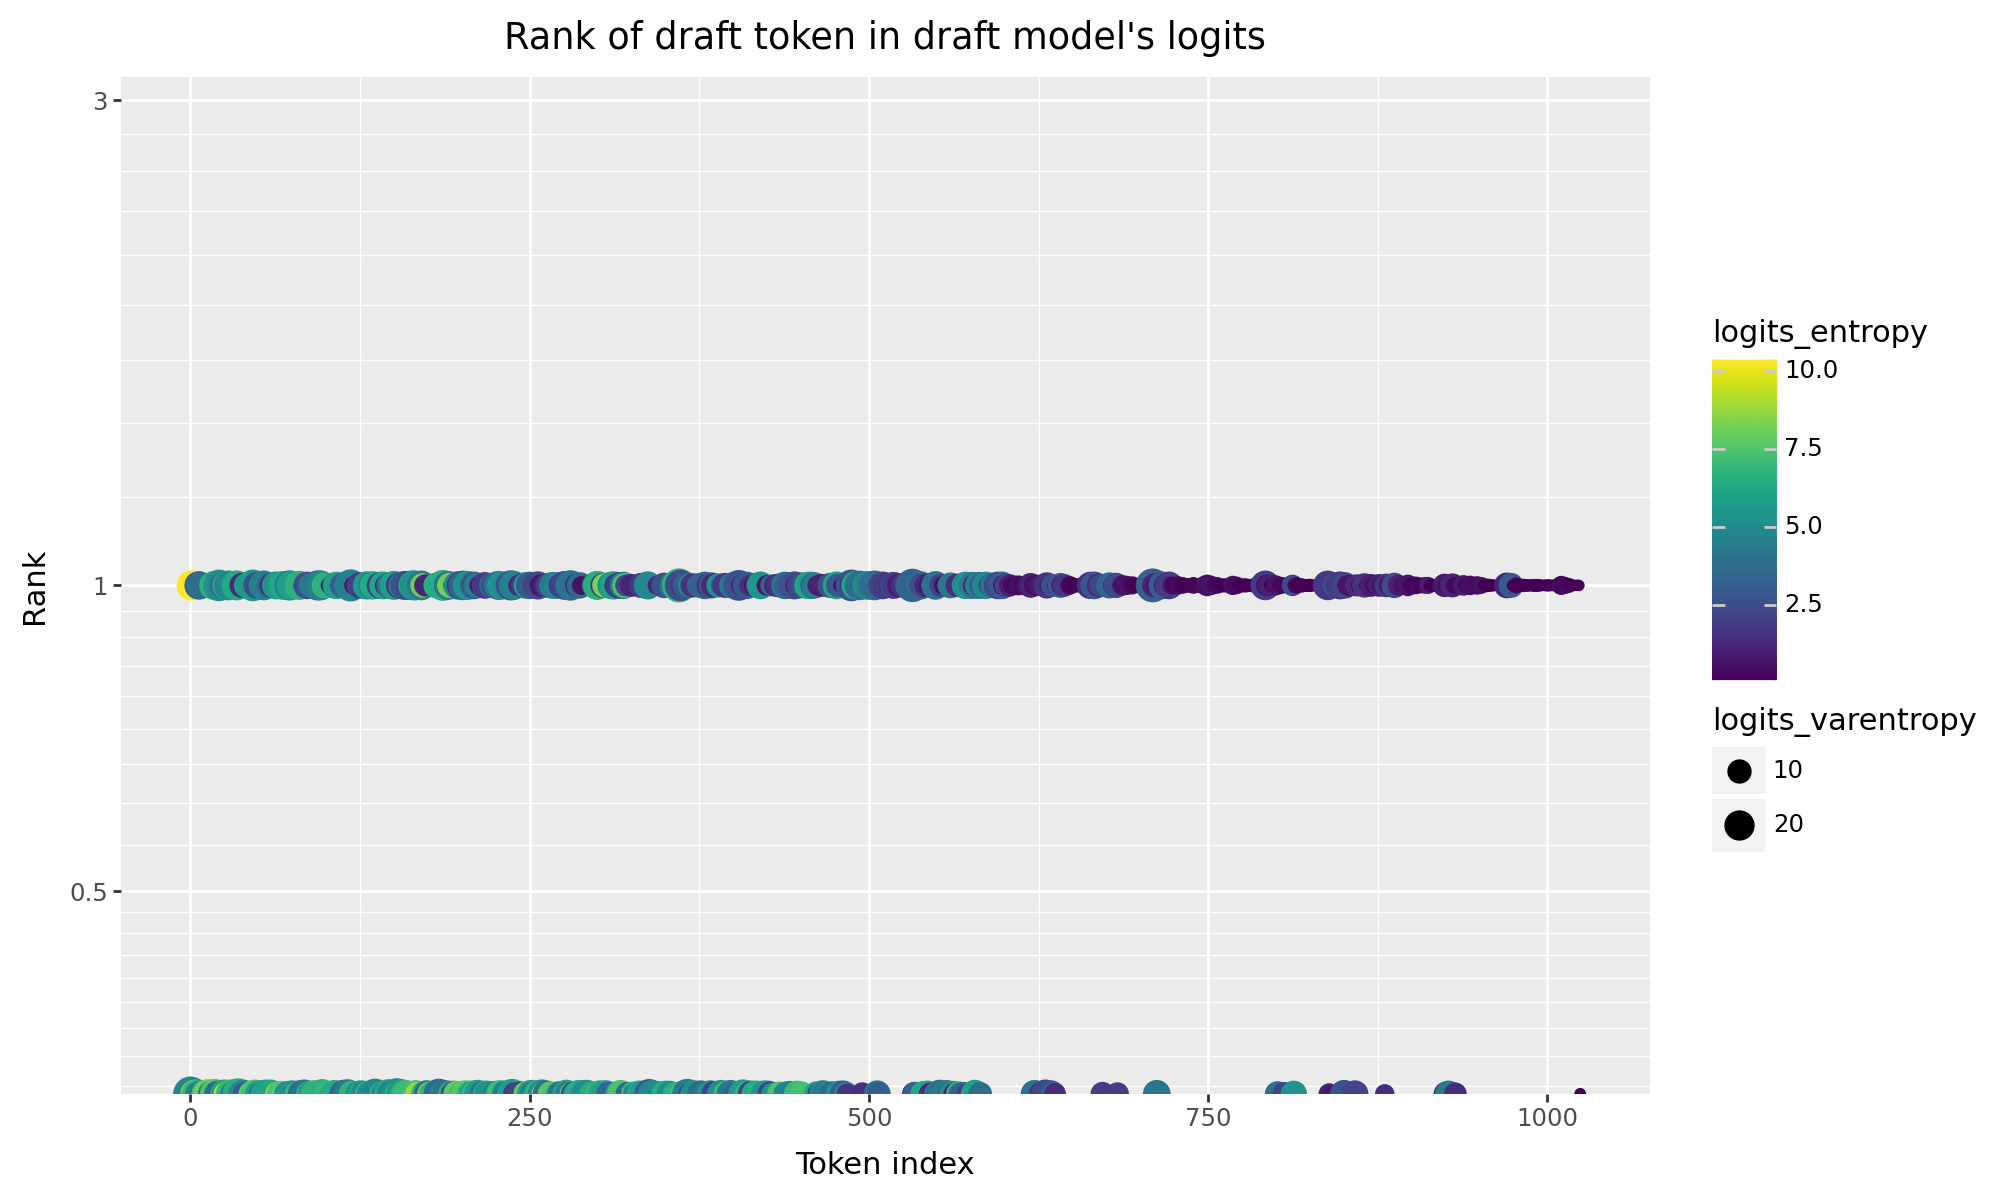

In [20]:
pn.ggplot(df_big.assign(index = df_big.index + 0.1), pn.aes(x="index", y="factor(rank==0)", color="logits_entropy", size="logits_varentropy")) + pn.geom_point() + pn.scale_y_log10() + pn.labs(title="Rank of draft token in draft model's logits", x="Token index", y="Rank") + pn.theme(figure_size=(10, 6)) 

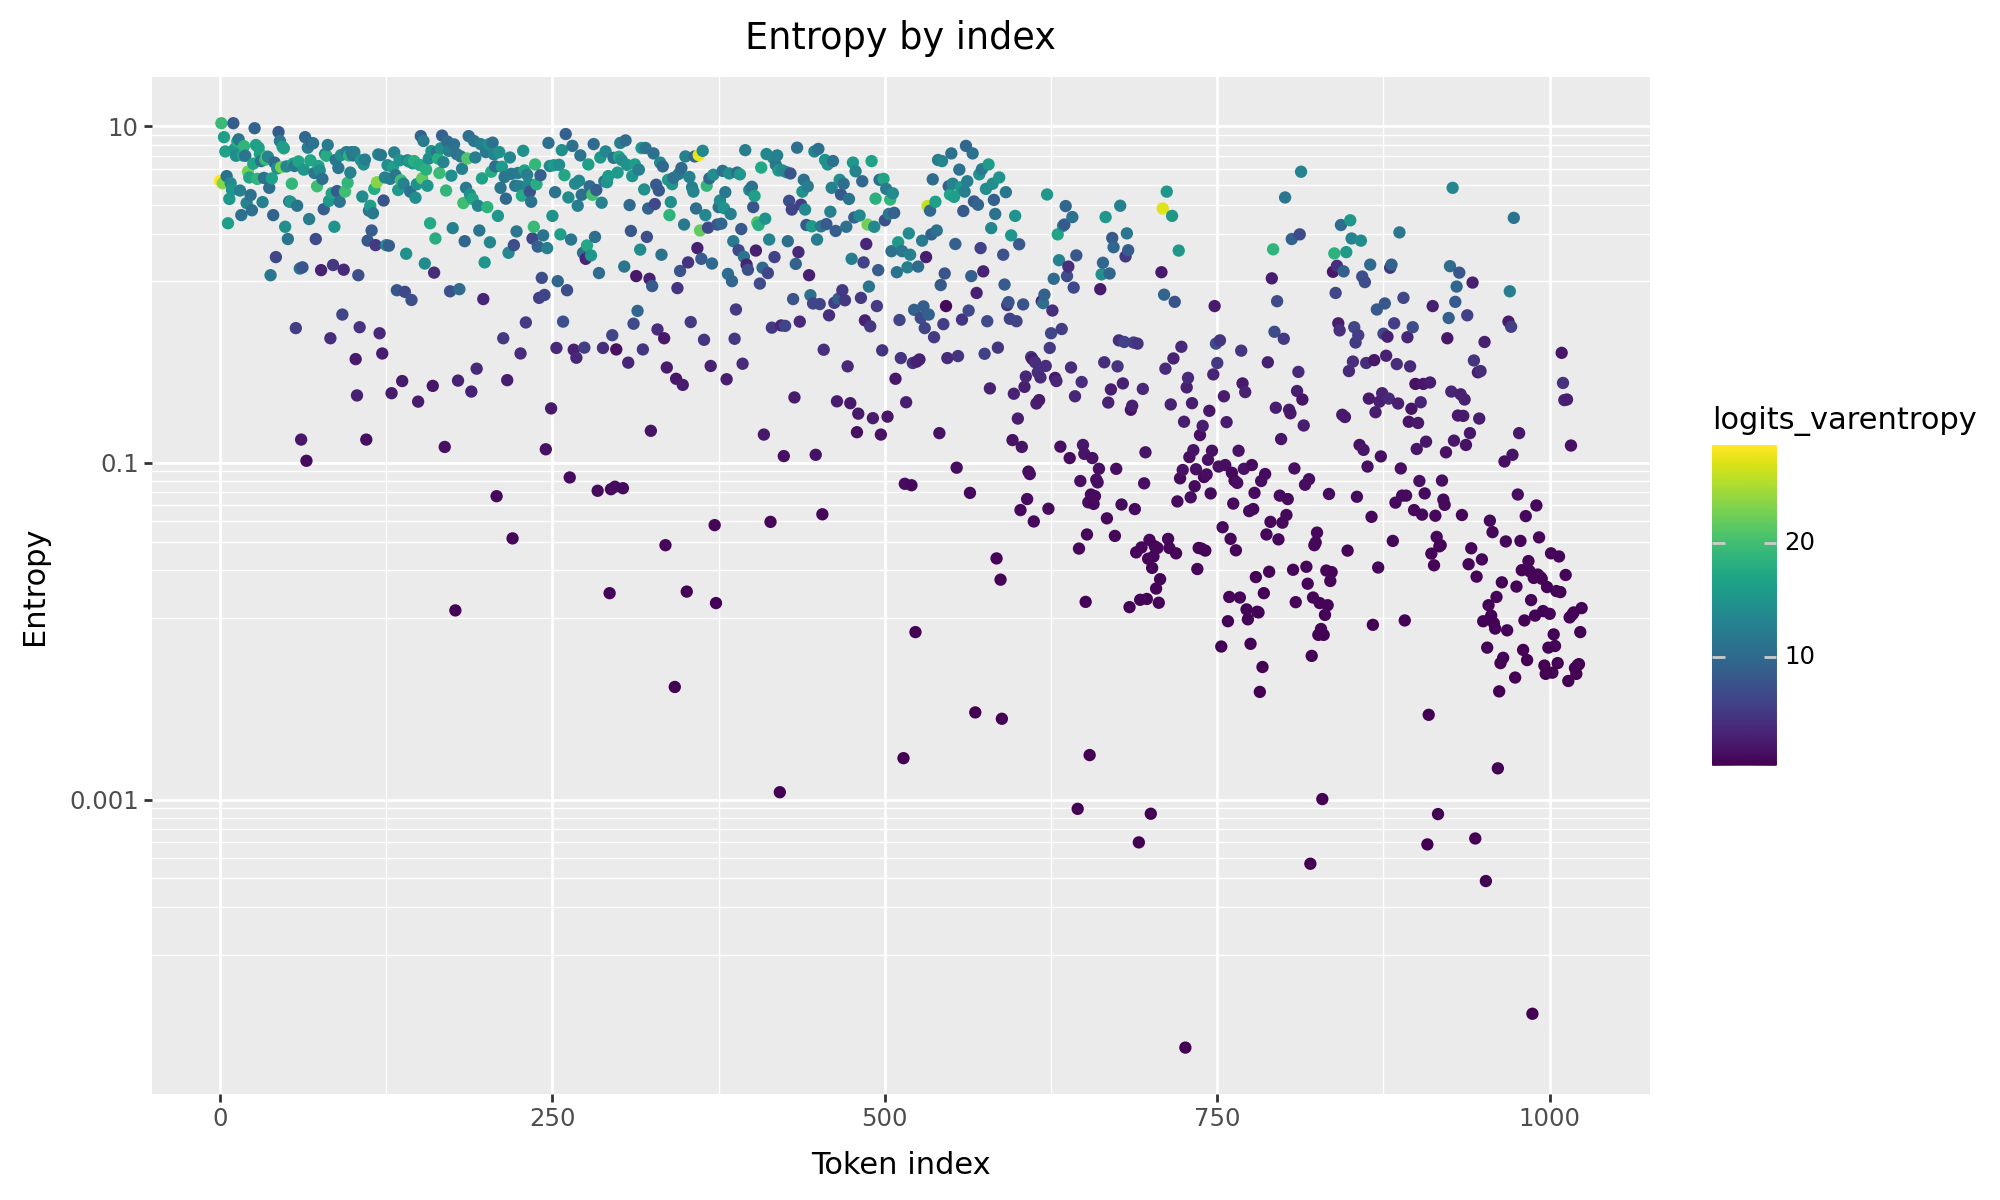

In [28]:
pn.ggplot(df_big.assign(index = df_big.index + 0.1), pn.aes(x="index", y="logits_entropy", color="logits_varentropy")) + pn.geom_point() + pn.scale_y_log10() + pn.labs(title="Entropy by index", x="Token index", y="Entropy") + pn.theme(figure_size=(10, 6)) 

[[ 0.04172797 -0.75341795  0.0251297 ]] [2.82566159]


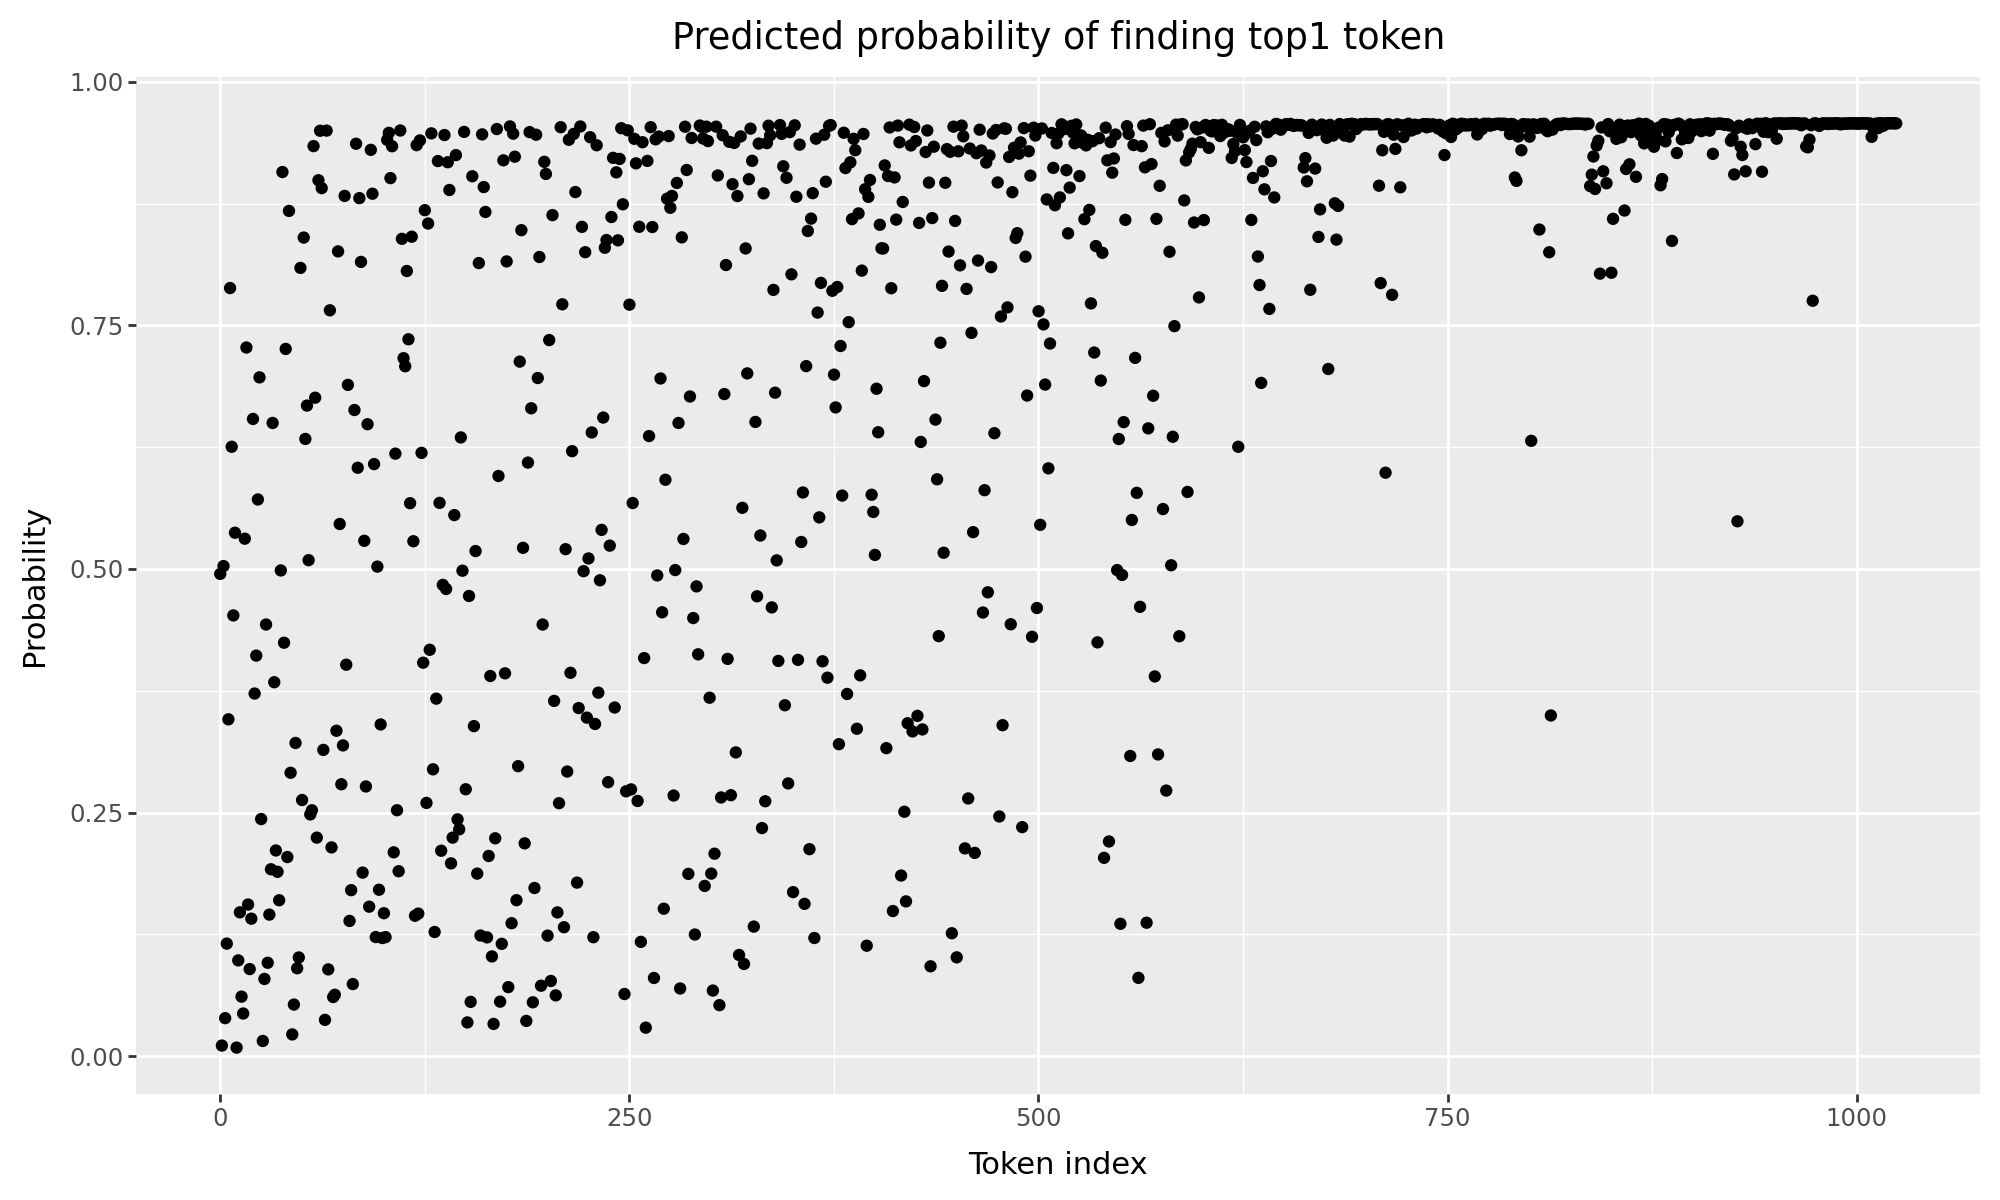

In [35]:
from sklearn.linear_model import LogisticRegression
import numpy as np
lr = LogisticRegression()

X = df_big[['index', 'logits_entropy', 'logits_varentropy']].assign(index = lambda x: np.log(x['index'] + 1))
y = df_big['found_top1']

lr.fit(X, y)

print(lr.coef_, lr.intercept_)

preds = lr.predict_proba(X)[:, 1]
df_big['preds'] = preds
pn.ggplot(df_big, pn.aes(x="index", y="preds")) + pn.geom_point() + pn.labs(title="Predicted probability of finding top1 token", x="Token index", y="Probability") + pn.theme(figure_size=(10, 6))

Feature Importances:
index: 0.000
logits_entropy: 0.932
logits_varentropy: 0.068


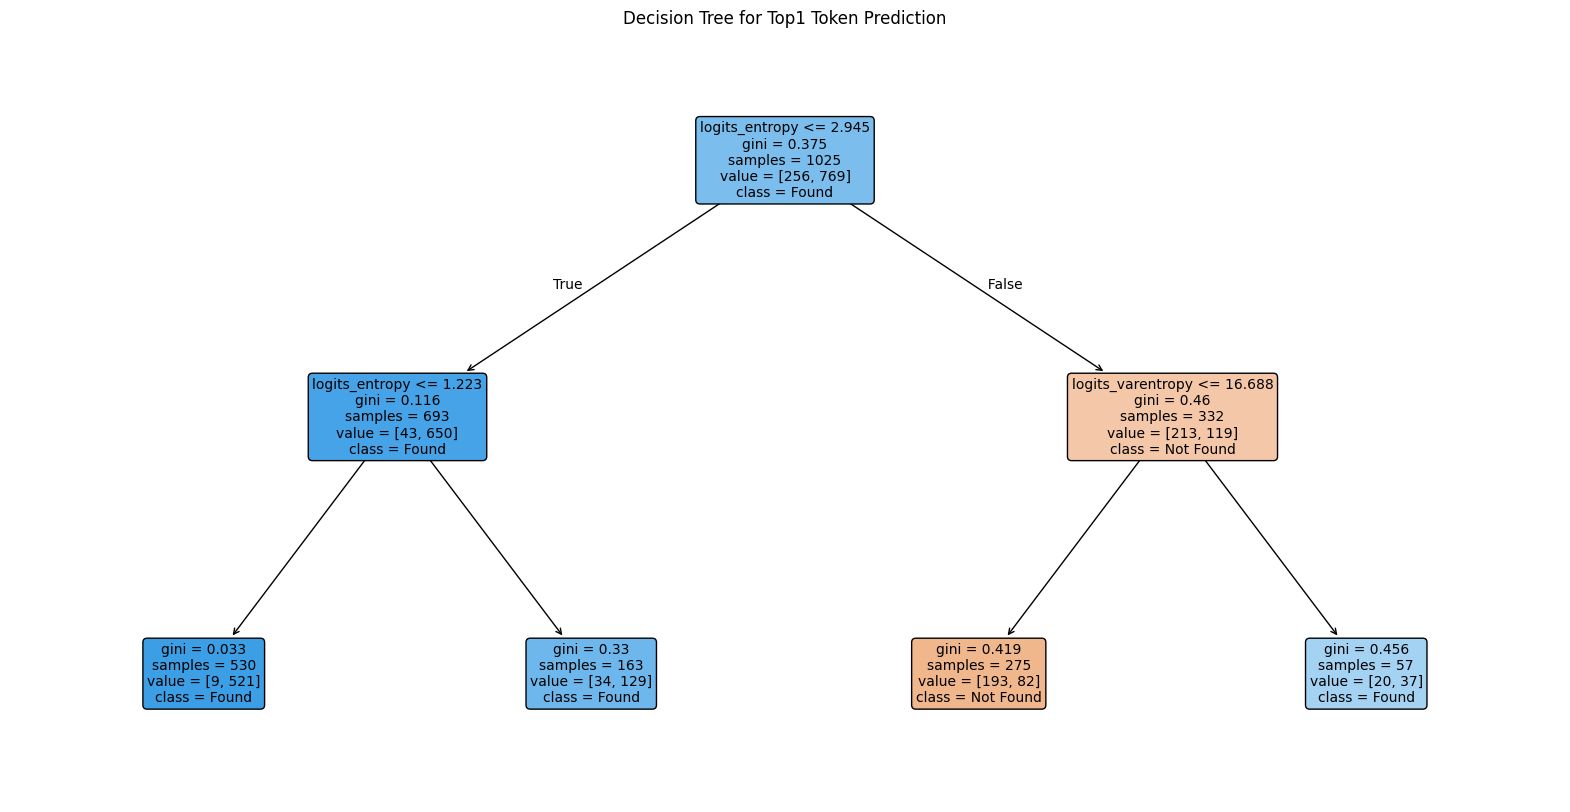

In [42]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Create and fit the decision tree
dt = DecisionTreeClassifier(max_depth=2, random_state=42)  # Limiting depth for interpretability

X = df_big[['index', 'logits_entropy', 'logits_varentropy']].assign(index = lambda x: np.log10(x['index'] + 1))
y = df_big['found_top1']

dt.fit(X, y)

# Print feature importances
feature_importance = dict(zip(X.columns, dt.feature_importances_))
print("Feature Importances:")
for feature, importance in feature_importance.items():
    print(f"{feature}: {importance:.3f}")

# Create visualization
plt.figure(figsize=(20,10))
plot_tree(dt, 
          feature_names=X.columns,
          class_names=['Not Found', 'Found'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree for Top1 Token Prediction")
plt.show()

# Calculate and store predictions
preds = dt.predict_proba(X)[:, 1]
df_big['preds'] = preds


/home/hua/code/entropix/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
/home/hua/code/entropix/.venv/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


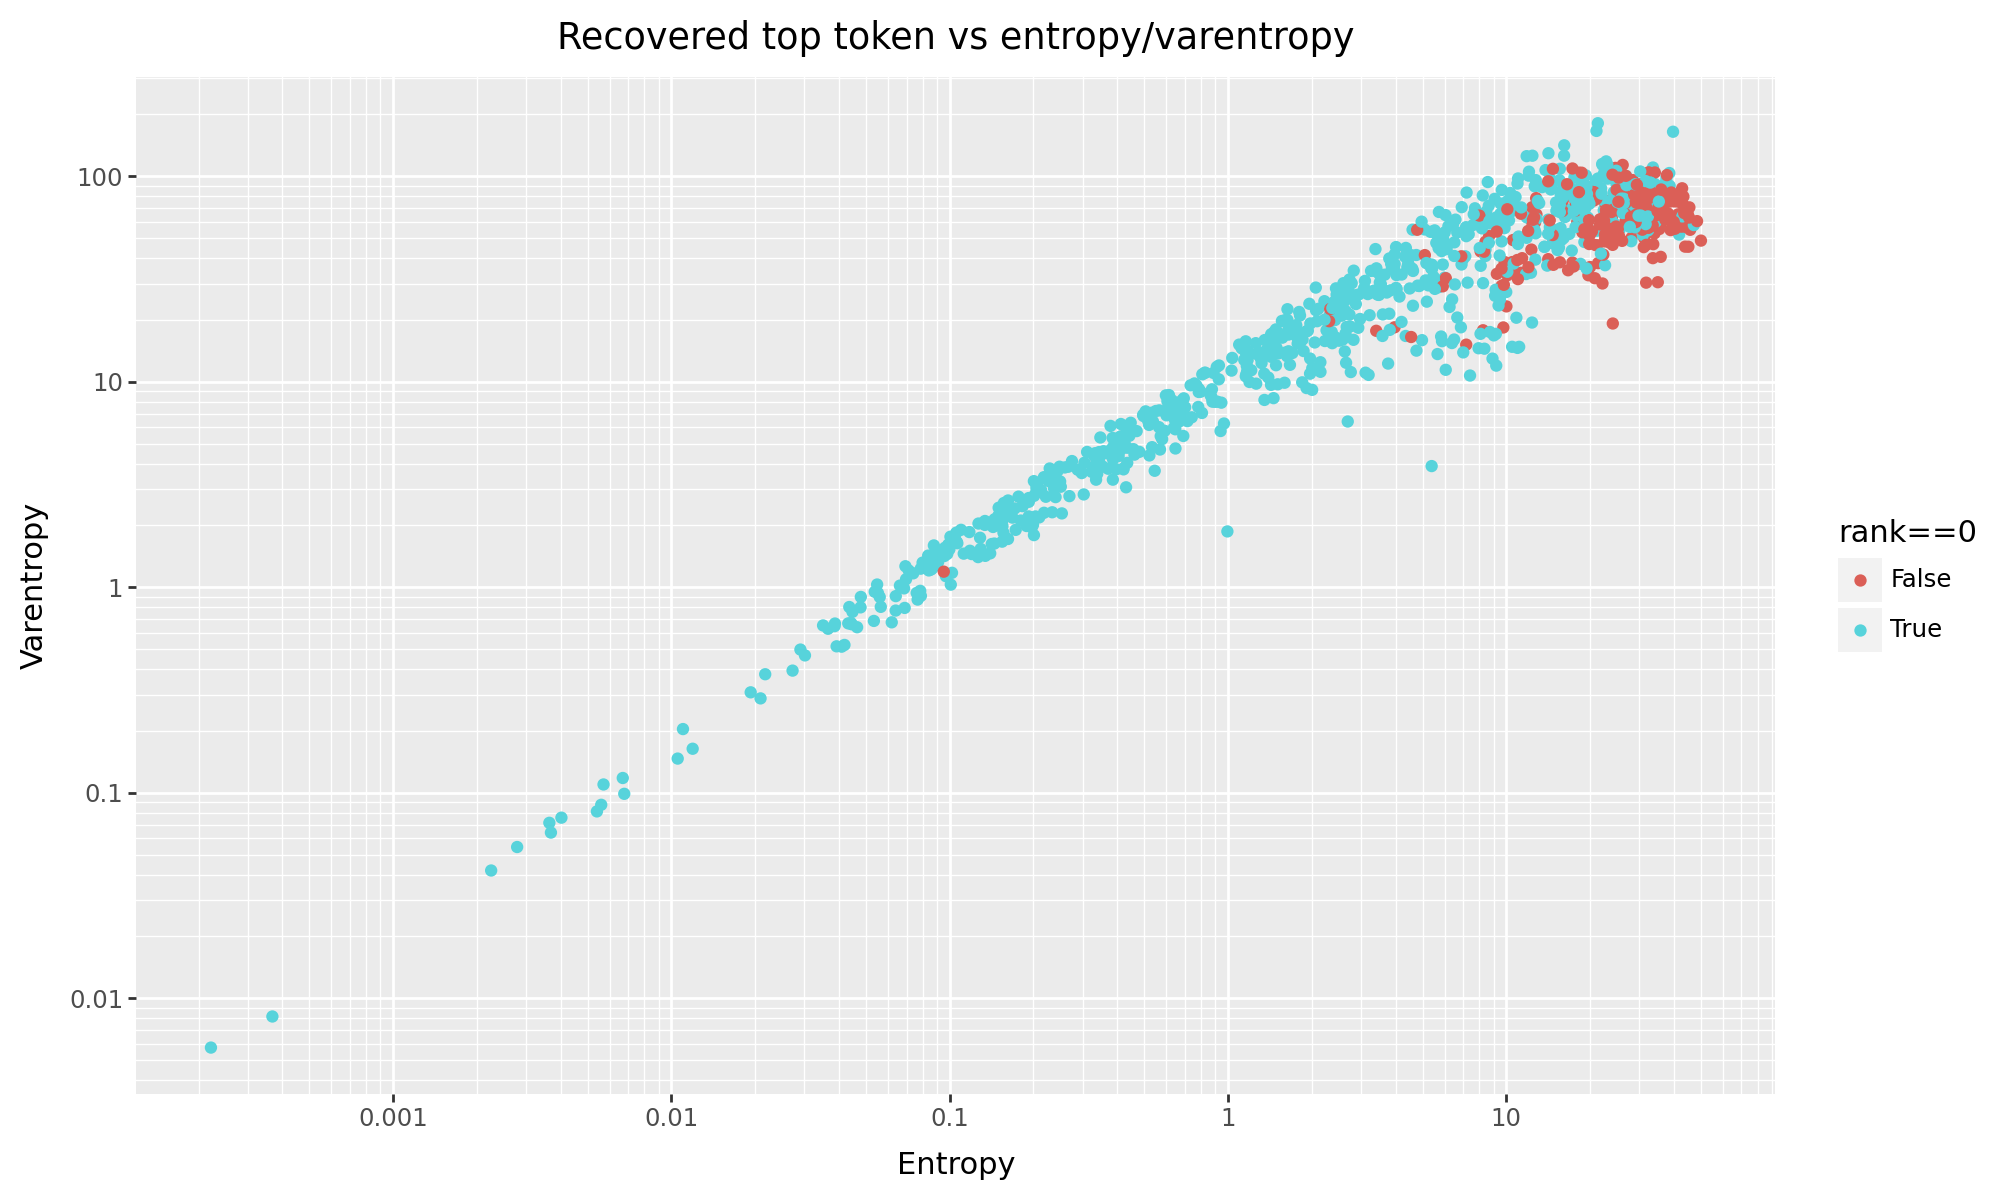

In [29]:
import numpy as np
# plot binary rank vs entropy

pn.ggplot(df_big.assign(logits_entropy=lambda x: x['logits_entropy'] * np.log(x['index']), logits_varentropy=lambda x: x['logits_varentropy'] * np.log(x['index'])),
          pn.aes(x="logits_entropy", y="logits_varentropy", color="rank==0")) + pn.geom_point() + pn.scale_x_log10() + pn.scale_y_log10() +  pn.labs(title="Recovered top token vs entropy/varentropy", x="Entropy", y="Varentropy") + pn.theme(figure_size=(10, 6))


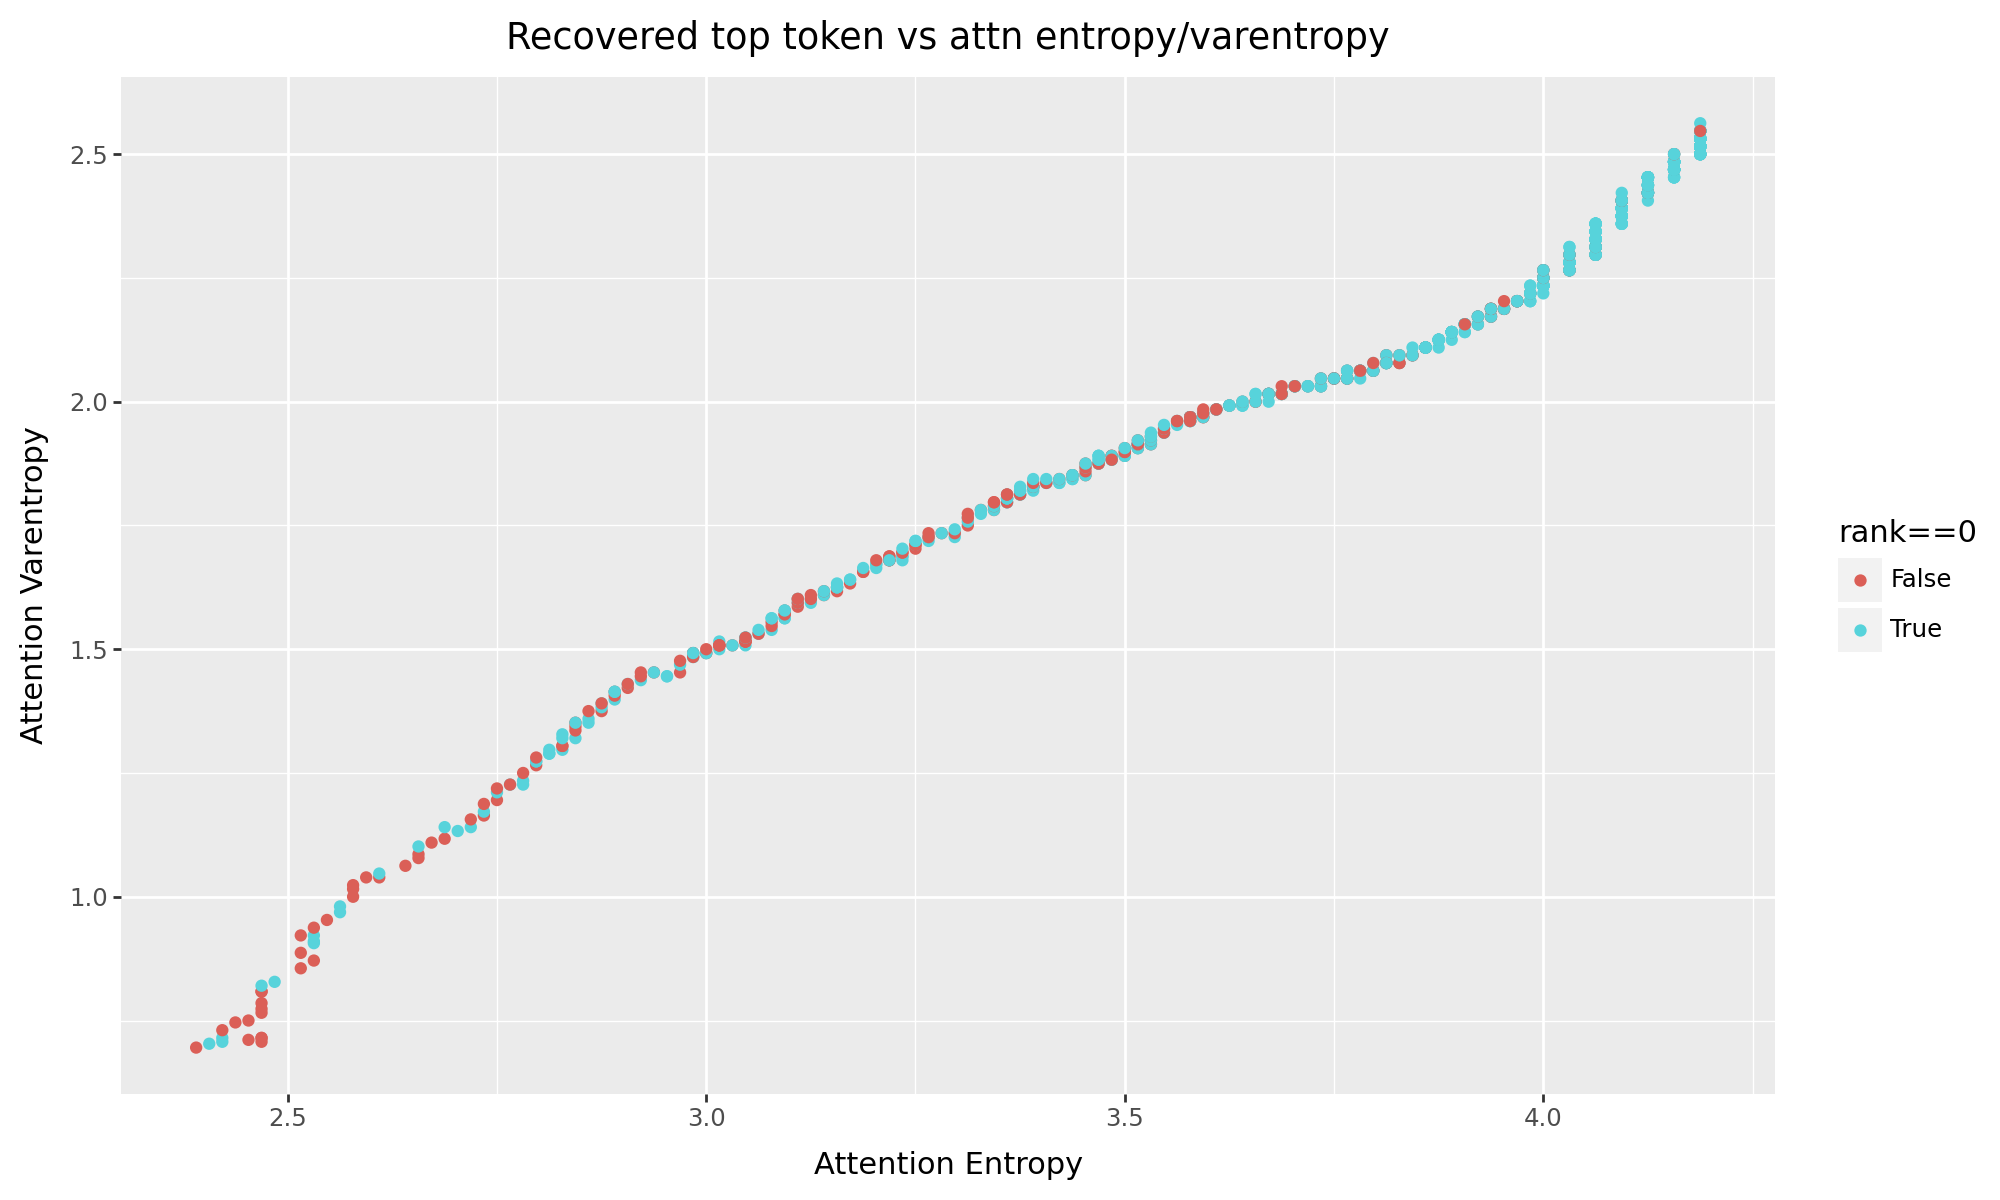

In [15]:
pn.ggplot(df_big, pn.aes(x="attn_entropy", y="attn_varentropy", color="rank==0")) + pn.geom_point() + pn.labs(title="Recovered top token vs attn entropy/varentropy", x="Attention Entropy", y="Attention Varentropy") + pn.theme(figure_size=(10, 6))


In [16]:
# plot timeseries of entropy and variance entropy and attn entropy and variance entropy

pn.ggplot(
    df.melt(id_vars="index", value_vars=["logits_entropy", "logits_varentropy", "logits_skewness", "logits_kurtosis"]),
    pn.aes(x="index", y="value", color="variable")
) + pn.geom_point() + pn.geom_line() + pn.labs(title="Entropy and variance entropy of draft model's logits", x="Token index", y="Entropy") + pn.theme(figure_size=(10, 6)) 

NameError: name 'df' is not defined

/home/hua/code/entropix/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
/home/hua/code/entropix/.venv/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/home/hua/code/entropix/.venv/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 1 rows containing missing values.


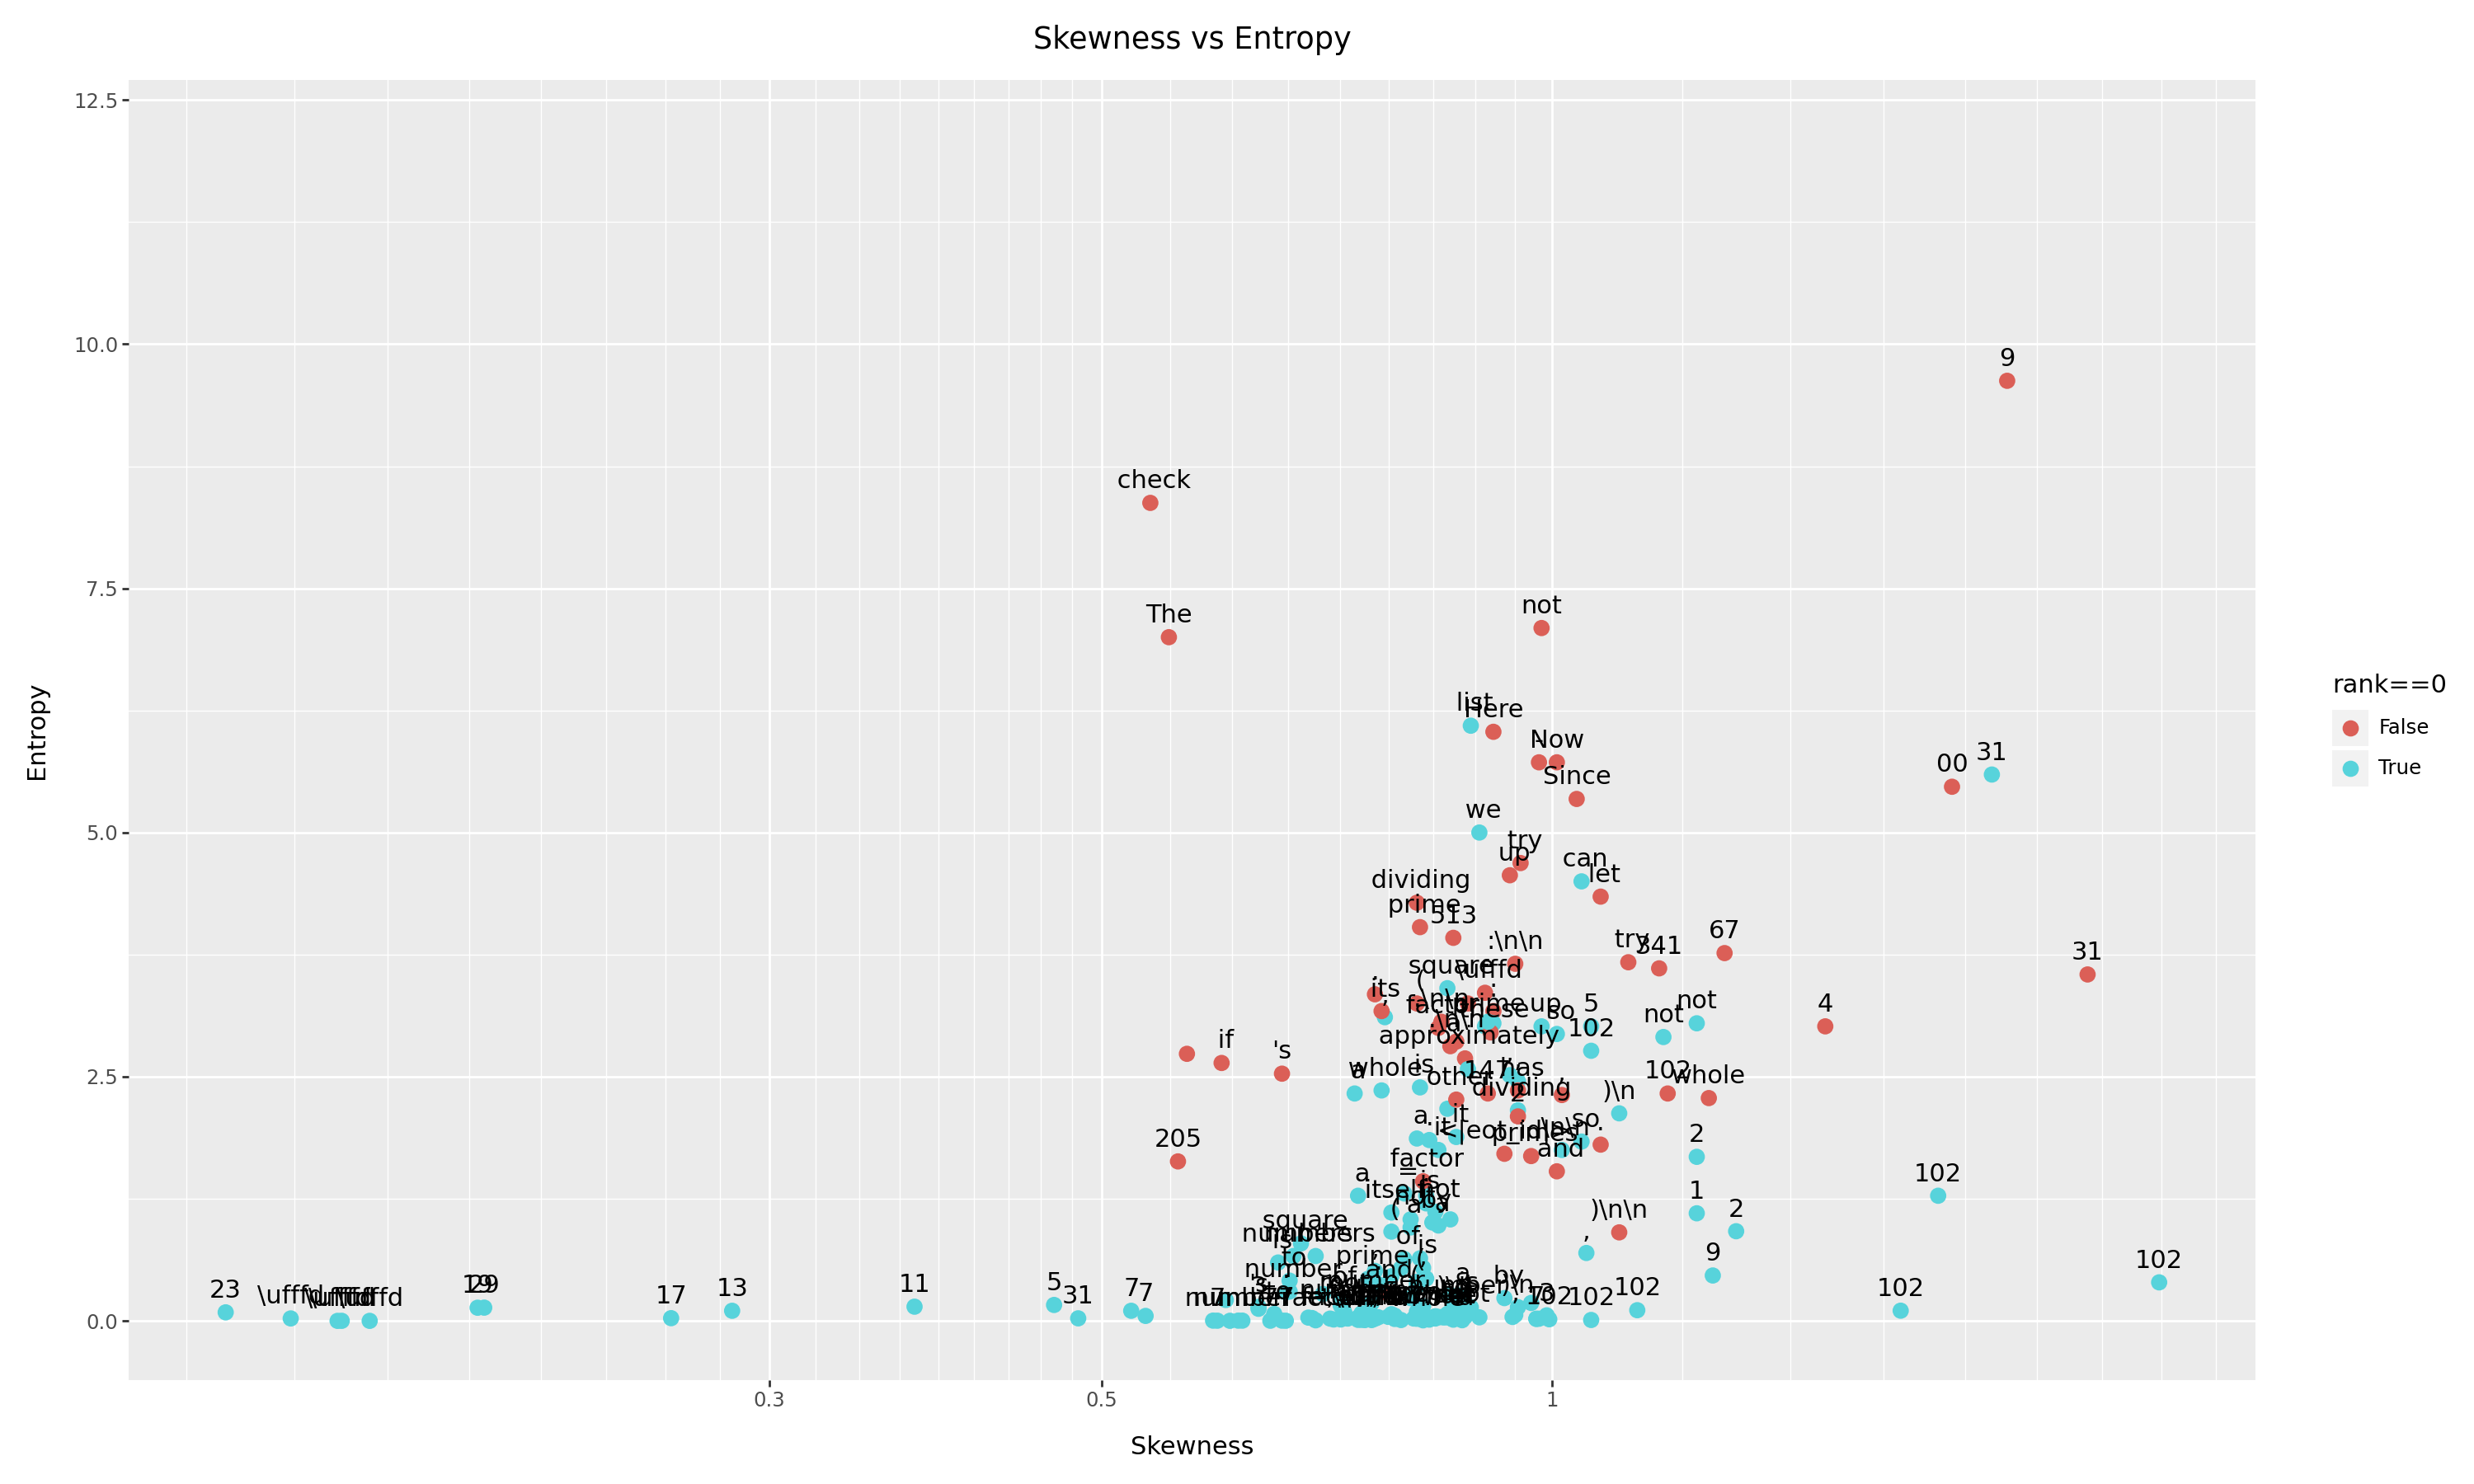

In [51]:
(pn.ggplot(df, 
               pn.aes(x='logits_skewness', 
                   y='logits_entropy')) 
    + pn.geom_point(pn.aes(color='rank==0'), 
                size=3)
    + pn.geom_text(pn.aes(label='token'), 
                va='bottom',
                ha='center',
                nudge_y=0.1)
    + pn.labs(
        title='Skewness vs Entropy',
        x='Skewness',
        y='Entropy'
    )
    + pn.scale_x_log10()
    + pn.theme(figure_size=(15, 9))
)

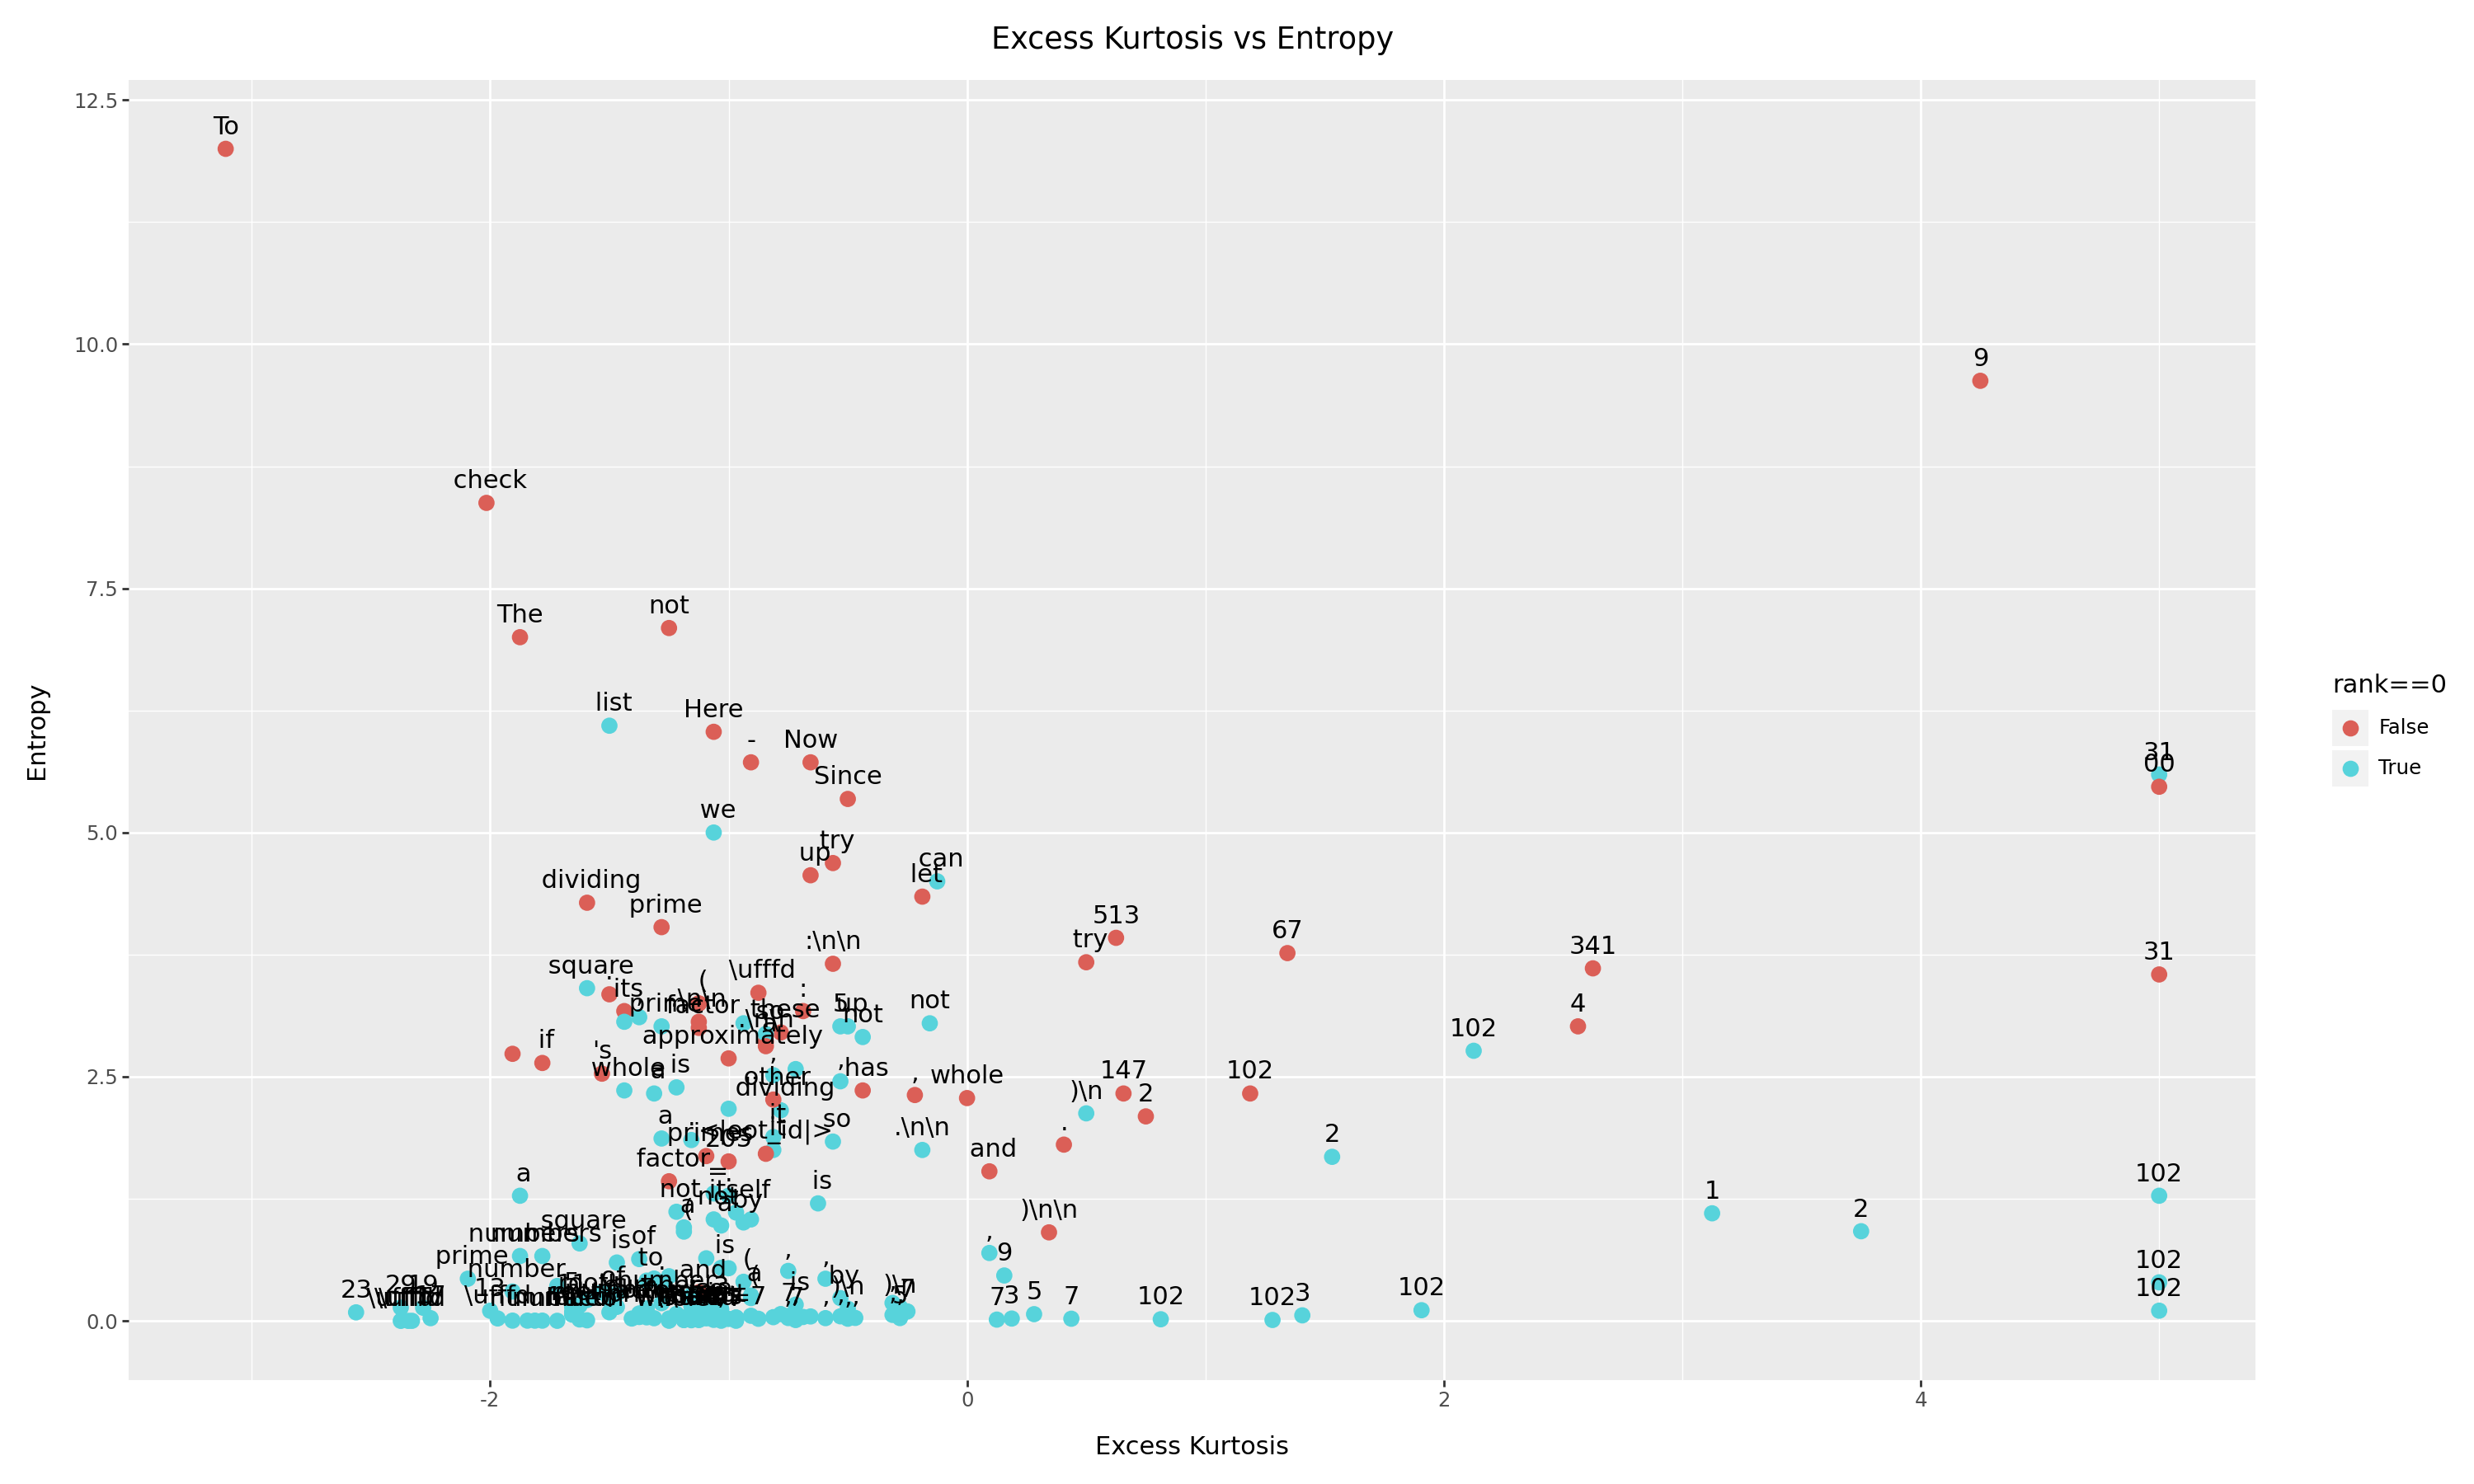

In [52]:
(pn.ggplot(df.assign(excess_kurtosis=lambda x: x['logits_kurtosis'] - 3).assign(excess_kurtosis=lambda x: x['excess_kurtosis'].clip(upper=5)),
               pn.aes(x='excess_kurtosis', 
                   y='logits_entropy')) 
    + pn.geom_point(pn.aes(color='rank==0'), 
                size=3)
    + pn.geom_text(pn.aes(label='token'), 
                va='bottom',
                ha='center',
                nudge_y=0.1)
    + pn.labs(
        title='Excess Kurtosis vs Entropy',
        x='Excess Kurtosis',
        y='Entropy'
    )
    + pn.theme(figure_size=(15, 9))
)